Import some libraries that we will need

In [25]:
%matplotlib inline
import scipy.io
from scipy.stats import stats
from sklearn.metrics import confusion_matrix
from sklearn.svm import NuSVC
import numpy as np

Run SRM with the movie data

In [26]:
import toolkit.srm
help(toolkit.srm.SRM)

Help on class SRM in module toolkit.srm.srm:

class SRM(sklearn.base.BaseEstimator)
 |  Probabilistic Shared Response Model (SRM)
 |  
 |  Given multi-subject data, factorize it as a shared response S among all subjects and an orthogonal transform W
 |  per subject:
 |  
 |  .. math:: X_i \sim W_i * S ,~for~all~i=1\dots N
 |  
 |  Parameters
 |  ----------
 |  
 |  n_iter : int, default: 10
 |      Number of iterations to run the algorithm.
 |  
 |  features : int, default: 50
 |      Number of features to compute.
 |  
 |  rand_seed : int, default: 0
 |      Seed for initializing the random number generator.
 |  
 |  verbose : boolean, default: False
 |      Verbose mode flag.
 |  
 |  
 |  Attributes
 |  ----------
 |  
 |  w_ : list of array, element i has shape=[voxels_i, features]
 |      The orthogonal transforms (mappings) for each subject.
 |  
 |  s_ : array, shape=[features, samples]
 |      The shared response.
 |  
 |  sigma_s_ : array, shape=[features, features]
 |      Th

Load the input data that contains the movie stimuli for unsupervised training with SRM

In [27]:
movie_data = scipy.io.loadmat('data/movie_data.mat')

Convert data to a list of arrays matching SRM input.
Each element is a matrix of voxels by TRs.

In [28]:
movie_data = list(movie_data['movie_data_lh'])
subjects = len(movie_data)

Z-score the data

In [29]:
for subject in range(subjects):
    movie_data[subject] = stats.zscore(movie_data[subject],axis=1,ddof=1)

Run SRM 

In [30]:
srm = toolkit.srm.SRM(n_iter=10, features=50, verbose=False)
srm.fit(movie_data)

SRM(features=50, n_iter=10, rand_seed=0, verbose=False)

Load the input data that contains the image stimuli and its labels for training a classifier

In [31]:
image_data = scipy.io.loadmat('data/image_data.mat')

Convert data to a list of arrays matching SRM input. Each element is a matrix of voxels by TRs.

In [32]:
image_data = list(image_data['image_data_lh'])

Z-score the image data

In [33]:
for subject in range(subjects):
    image_data[subject] = stats.zscore(image_data[subject],axis=1,ddof=1)

Transform the data to the shared response subspace

In [34]:
image_data_shared = [None] * subjects
for subject in range(subjects):
    image_data_shared[subject] = srm.w_[subject].T.dot(image_data[subject])
    image_data_shared[subject] = stats.zscore(image_data_shared[subject], axis=1, ddof=1)

Read the labels of the image data

In [35]:
labels = scipy.io.loadmat('data/label.mat')
labels = np.squeeze(labels['label'])

Run a leave-one-out cross validation with the subjects. We use a $\nu$-SVM classifier.

In [36]:
train_labels = np.tile(labels, subjects-1)
test_labels = labels
accuracy = np.zeros((subjects))
cm = [None] * subjects
for subject in range(subjects):
    # Concatenate the subjects' data for training into one matrix
    train_subjects = list(range(subjects))
    train_subjects.remove(subject)
    TRs = image_data_shared[0].shape[1]
    train_data = np.zeros((image_data_shared[0].shape[0], len(train_labels)))
    for train_subject in range(len(train_subjects)):
        start_index = train_subject*TRs
        end_index = start_index+TRs
        train_data[:, start_index:end_index] = image_data_shared[train_subjects[train_subject]]

    # Train a Nu-SVM classifier using scikit learn
    classifier = NuSVC(nu=0.5, kernel='linear')
    classifier = classifier.fit(train_data.T, train_labels)

    # Predict on the test data
    predicted_labels = classifier.predict(image_data_shared[subject].T)
    accuracy[subject] = sum(predicted_labels == test_labels)/float(len(predicted_labels))

    # Create a confusion matrix to see the accuracy of each class
    cm[subject] = confusion_matrix(test_labels, predicted_labels)

    # Normalize the confusion matrix
    cm[subject] = cm[subject].astype('float') / cm[subject].sum(axis=1)[:, np.newaxis]

Define a function that presents the output of the experiment in a plot

In [37]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plots a confusion matrix for each subject"""
    import matplotlib.pyplot as plt
    import math
    plt.figure()
    subjects = len(cm)
    root_subjects = math.sqrt(subjects)
    cols = math.ceil(root_subjects)
    rows = math.ceil(subjects/cols)
    classes = cm[0].shape[0]
    for subject in range(subjects):
        plt.subplot(rows, cols, subject+1)
        plt.imshow(cm[subject], interpolation='nearest', cmap=plt.cm.bone)
        plt.xticks(np.arange(classes), range(1,classes+1))
        plt.yticks(np.arange(classes), range(1,classes+1))
        cbar = plt.colorbar(ticks=[0.0,1.0], shrink=0.6)
        cbar.set_clim(0.0, 1.0)
        plt.xlabel("Predicted")
        plt.ylabel("True label")
        plt.title("{0:d}".format(subject + 1))
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

 Plot the confusion matrices and print the accuracy results

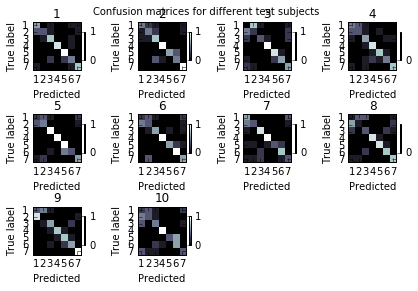

The average accuracy among all subjects is 0.614286 +/- 0.064976


In [38]:
plot_confusion_matrix(cm, title="Confusion matrices for different test subjects")
print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accuracy), np.std(accuracy)))